# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.head(10))
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39
Found 7591 validated image filenames.


In [3]:
print(labels.info())
labels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


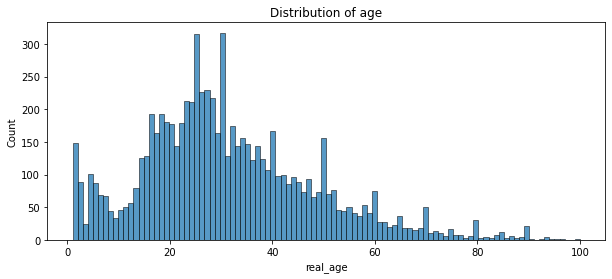

In [5]:
plt.figure(figsize=(10,4))
sns.histplot(labels.real_age, kde=False, bins=100)
plt.title("Distribution of age")
plt.show()

В датасете по большей части люди в возрасте 20-25 лет. Отмечены пики на 1, 25, 30 и последующие юбилейные возраста. Вполне похоже на округление при недостатке данных. Данных людей старше 40 лет значительно меньше, что может искажать результаты обучения, модель чаще всего будет определять возраст 20-40 лет.

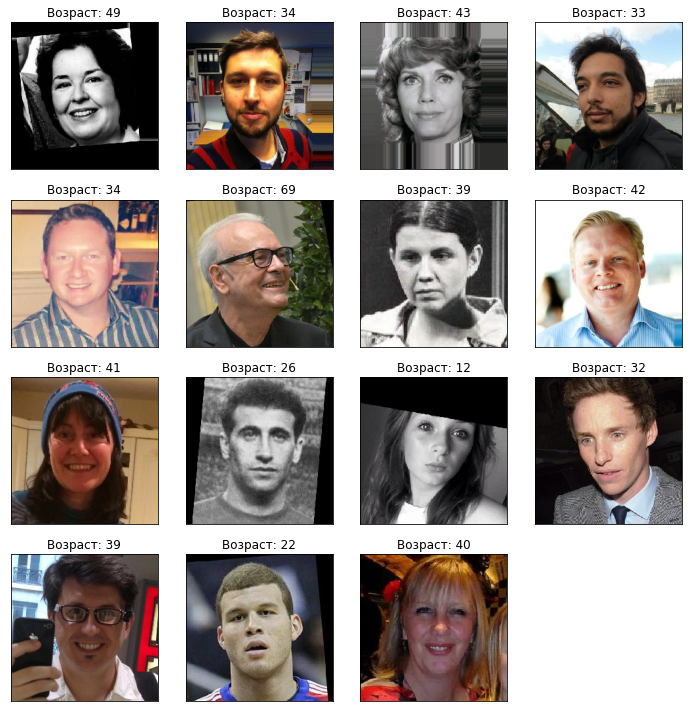

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Возраст: {target[i]}")
    plt.tight_layout()


## Вывод по данным
В датасете 7591 фотографий. Разметка данных выполнена верно. Учитывая задачу, в которой мы применяем методы регрессии определяя по фотографии лишь один непрерывный численный признак - данных достаточно. Преимущественный возраст в датасете 20-30 лет. Отмечены пики на 1, 25, 30 и последующие юбилейные возраста. Вполне похоже на округление при недостатке данных. 
Изображения имеют разную яркость и контрастность. К тому же некоторые лица сфотографированы в профиль, а также у части изображений имеют черные поля по краям вследствие наклона или нарушения центровки. Эти факторы могут усложнить обучение модели, придется применять методы аугментации и учитывать особенности изображений при построении модели.

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    df = pd.read_csv('/datasets/faces/labels.csv')
    
    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 178 steps, validate for 60 steps

Epoch 1/5

178/178 - 115s - loss: 232.3149 - mae: 11.0582 - val_loss: 904.4547 - val_mae: 25.2433

Epoch 2/5

178/178 - 92s - loss: 91.5958 - mae: 7.2544 - val_loss: 824.3635 - val_mae: 23.6823

Epoch 3/5

178/178 - 91s - loss: 72.1884 - mae: 6.4553 - val_loss: 308.6969 - val_mae: 13.0112

Epoch 4/5

Epoch 5/5

178/178 - 92s - loss: 55.7958 - mae: 5.7311 - val_loss: 125.9313 - val_mae: 8.2816

178/178 - 92s - loss: 47.4009 - mae: 5.2719 - val_loss: 78.6474 - val_mae: 6.5711


60/60 - 10s - loss: 78.6474 - mae: 6.5711

Test MAE: 6.5711

```

## Анализ обученной модели

Применили методы аугментации к загружаемым с помощью загрузчика изображениям. Мы обучили архитектуру ResNet50 со слоем усреднения значений и однонейронным выходным слоем с методом активации ReLU. Алгоритмом обучения был выбран Adam. За 5 эпох был достигнут показатель MAE = 6.5711 .

Модель имеет погрешность в определении возраста величиной в 6,5 лет, что довольно много, но выполняет поставленную задачу приблизительного определения возраста. Ее можно использовать, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. В целях контроля добросовестности кассиров при продаже алкоголя скорее поможет другая техника: классификация изображений по признакам совершеннолетние\несовершеннолетние. MAE с ошибкой определенеия возраста в данном случае использовать некорректно и небезопасно.

В данных имеется дисбаланс классов: людей старше 40 лет значительно меньше, что послужить причиной недостаточно точных результатов обучения, только лишь методами аугментации данную проблему не решить